## CDS 301

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [2]:
def read_csv(file_path):
    return pd.read_csv(open(file_path))

gpu_specs_path = "./data/GPU_Specs.csv"
gpu_scores_path = "./data/GPU_Scores.csv"
gpu_benchmark_path = "./data/GPU_Benchmarks.csv"

df_specs = read_csv(gpu_specs_path)
df_scores = read_csv(gpu_scores_path)
df_benchmarks = read_csv(gpu_benchmark_path)

## Data Previewing

In [3]:
### SIZE OF DATAFRAMES ###
def preview_size(idx, dataframe):
    print(idx,"-",dataframe.shape)

preview_size("Specs", df_specs)
preview_size("Scores", df_scores)
preview_size("Benchmarks", df_benchmarks)

Specs - (3056, 16)
Scores - (1213, 6)
Benchmarks - (2317, 9)


In [4]:
### DATA DICTIONARY ###
def data_dictionary(dataframe):
    new_df = pd.DataFrame({"Column": [], "Type": [], "Missing Data": [], "Percentage Missing": []})
    for column in dataframe.columns:
        new_df.loc[len(new_df)] = {"Column": str(column), "Type": dataframe[column].dtype, "Missing Data": dataframe[column].isna().sum(), "Percentage Missing": round((dataframe[column].isna().sum()/len(dataframe[column])*100), 2)}
    return new_df


In [5]:
data_dictionary(df_specs)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.00
1,productName,object,0,0.00
2,releaseYear,float64,44,1.44
3,memSize,float64,441,14.43
4,memBusWidth,float64,2868,93.85
5,gpuClock,int64,0,0.00
6,memClock,float64,441,14.43
7,unifiedShader,float64,824,26.96
8,tmu,int64,0,0.00
9,rop,int64,0,0.00


In [6]:
data_dictionary(df_scores)

,Column,Type,Missing Data,Percentage Missing
0,Manufacturer,object,0,0.00
1,Device,object,0,0.00
2,CUDA,float64,947,78.07
3,Metal,float64,972,80.13
4,OpenCL,float64,237,19.54
5,Vulkan,float64,584,48.15


In [7]:
data_dictionary(df_benchmarks)

,Column,Type,Missing Data,Percentage Missing
0,gpuName,object,0,0.00
1,G3Dmark,int64,0,0.00
2,G2Dmark,int64,0,0.00
3,price,float64,1764,76.13
4,gpuValue,float64,1764,76.13
5,TDP,float64,1625,70.13
6,powerPerformance,float64,1625,70.13
7,testDate,int64,0,0.00
8,category,object,0,0.00


In [8]:
df_specs.head()

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 5090,2025.0,28.0,448.0,900,1200.0,8192.0,256,128,NaN,NaN,No,PCIe 4.0 x16,HBM2e,Arctic Sound
1,NVIDIA,GeForce RTX 5080,2025.0,16.0,256.0,900,1215.0,6912.0,432,192,NaN,NaN,No,PCIe 4.0 x16,HBM2e,GA100
2,NVIDIA,GeForce RTX 5070,2025.0,12.0,192.0,1825,2000.0,5120.0,320,128,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 21
3,NVIDIA,GeForce RTX 5060 Mobile,2025.0,8.0,128.0,2235,2500.0,4608.0,144,48,NaN,NaN,No,PCIe 5.0 x16,GDDR7,GB206
4,NVIDIA,GeForce RTX 5060,2025.0,8.0,128.0,1825,2250.0,4608.0,288,192,NaN,NaN,No,PCIe 4.0 x16,GDDR6,Navi 31


## Data Cleaning

In [9]:
### Cleaning df_specs ###
df_specs_final = df_specs.drop(columns=["memBusWidth", "pixelShader", "vertexShader"])
df_specs_final = df_specs_final.rename(columns={"productName": "product_name", "releaseYear": "release_year",
                                                "memSize": "memory_size", "gpuClock": "gpu_clock", "memClock": "memory_clock",
                                                "unifiedShader": "unified_shader", "tmu": "texture_mapping_units", "rop": "render_output_units",
                                                "igp": "integrated_graphics_processor", "memType": "memory_type", "gpuChip": "gpu_chip"})
df_specs_final["integrated_graphics_processor"] = df_specs_final["integrated_graphics_processor"].map({"Yes": 1, "No": 0}).astype(bool)
df_specs_final["manufacturer"] = df_specs_final["manufacturer"].str.lower()
df_specs_final["product_name"] = df_specs_final["product_name"].str.lower()
df_specs_final = df_specs_final.dropna(subset=["release_year"])
df_specs_final['memory_size'] = df_specs_final.groupby('release_year')['memory_size'].transform(lambda x: x.fillna(x.median()))
df_specs_final['memory_clock'] = df_specs_final.groupby('release_year')['memory_clock'].transform(lambda x: x.fillna(x.median()))
df_specs_final['unified_shader'] = df_specs_final.groupby('release_year')['unified_shader'].transform(lambda x: x.fillna(x.median()))
df_specs_final['unified_shader'] = df_specs_final.groupby('release_year')['unified_shader'].transform(lambda x: x.fillna(0))
df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
df_specs_final["memory_type"] = df_specs_final["memory_type"].fillna("None")
data_dictionary(df_specs_final)

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4599/1867500982.py:15: SyntaxWarning: invalid escape sequence '\s'
  df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
/tmp/ipykernel_4599/1867500982.py:15: SyntaxWarning: invalid escape sequence '\s'
  df_specs_final["memory_type"] = df_specs_final["memory_type"].replace("^\s+", "", regex=True).replace("\s+$", "", regex=True)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/codespace/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/code

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,release_year,float64,0,0.0
3,memory_size,float64,0,0.0
4,gpu_clock,int64,0,0.0
5,memory_clock,float64,0,0.0
6,unified_shader,float64,0,0.0
7,texture_mapping_units,int64,0,0.0
8,render_output_units,int64,0,0.0
9,integrated_graphics_processor,bool,0,0.0


In [10]:
df_specs_final.shape

(3012, 13)

In [11]:
for i in range(2000,2025,1):
    print(i, (df_specs_final["release_year"] == i).sum())

2000 32
2001 41
2002 70
2003 120
2004 132
2005 97
2006 129
2007 156
2008 174
2009 106
2010 148
2011 170
2012 173
2013 225
2014 149
2015 165
2016 109
2017 110
2018 93
2019 105
2020 86
2021 88
2022 98
2023 100
2024 21


In [12]:
df_specs_final.head()

,manufacturer,product_name,release_year,memory_size,gpu_clock,memory_clock,unified_shader,texture_mapping_units,render_output_units,integrated_graphics_processor,bus,memory_type,gpu_chip
0,nvidia,geforce rtx 5090,2025.0,28.0,900,1200.0,8192.0,256,128,False,PCIe 4.0 x16,HBM2e,Arctic Sound
1,nvidia,geforce rtx 5080,2025.0,16.0,900,1215.0,6912.0,432,192,False,PCIe 4.0 x16,HBM2e,GA100
2,nvidia,geforce rtx 5070,2025.0,12.0,1825,2000.0,5120.0,320,128,False,PCIe 4.0 x16,GDDR6,Navi 21
3,nvidia,geforce rtx 5060 mobile,2025.0,8.0,2235,2500.0,4608.0,144,48,False,PCIe 5.0 x16,GDDR7,GB206
4,nvidia,geforce rtx 5060,2025.0,8.0,1825,2250.0,4608.0,288,192,False,PCIe 4.0 x16,GDDR6,Navi 31


In [13]:
df_specs_final[df_specs_final["memory_type"] == "GDDR6"][["manufacturer", "release_year", "memory_clock", "memory_type"]]

,manufacturer,release_year,memory_clock,memory_type
2,nvidia,2025.0,2000.0,GDDR6
4,nvidia,2025.0,2250.0,GDDR6
5,nvidia,2025.0,2000.0,GDDR6
11,nvidia,2024.0,2250.0,GDDR6
16,nvidia,2024.0,1750.0,GDDR6
...,...,...,...,...
2411,sony,2005.0,1937.0,GDDR6
2508,sony,2004.0,1750.0,GDDR6
2522,ati,2004.0,1250.0,GDDR6
2523,ati,2004.0,1250.0,GDDR6


In [14]:
df_specs_final["memory_type"].unique()

array(['HBM2e', 'GDDR6', 'GDDR7', 'HBM3e', 'HBM3', 'GDDR6X', 'DDR',
       'HBM2', 'GDDR3', 'DDR2', 'HBM', 'GDDR5X', 'GDDR5', 'LPDDR5',
       'DDR3', 'None', 'SDR', 'DDR4', 'GDDR4', 'eDRAM', 'LPDDR4X', 'SGR',
       'EDO', 'DRAM', 'GDDR2', 'FPM', 'VRAM', 'SGRAM', 'CDRAM'],
      dtype=object)

In [15]:
### Cleaning df_scores ###
df_scores_final = df_scores.copy()
df_scores_final["CUDA"] = df_scores_final["CUDA"].fillna(0)
df_scores_final["Metal"] = df_scores_final["Metal"].fillna(0)
df_scores_final["OpenCL"] = df_scores_final["OpenCL"].fillna(0)
df_scores_final["Vulkan"] = df_scores_final["Vulkan"].fillna(0)
df_scores_final = df_scores_final.rename(columns={"Manufacturer": "manufacturer", "Device": "product_name"})
df_scores_final["manufacturer"] = df_scores_final["manufacturer"].str.lower()
df_scores_final["product_name"] = df_scores_final["product_name"].str.lower()
data_dictionary(df_scores_final)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,CUDA,float64,0,0.0
3,Metal,float64,0,0.0
4,OpenCL,float64,0,0.0
5,Vulkan,float64,0,0.0


In [16]:
(df_scores_final["CUDA"] != 0).sum() / df_scores_final.shape[0] * 100


np.float64(21.929101401483926)

In [17]:
(df_scores_final["Metal"] != 0).sum()/ df_scores_final.shape[0]* 100

np.float64(19.868095630667764)

In [18]:
(df_scores_final["OpenCL"] != 0).sum()/ df_scores_final.shape[0]* 100

np.float64(80.46166529266281)

In [19]:
(df_scores_final["Vulkan"] != 0).sum()/ df_scores_final.shape[0]* 100

np.float64(51.854905193734545)

In [20]:
df_scores_final.shape

(1213, 6)

In [21]:
### Cleaning df_benchmarks ###
df_benchmarks_final = df_benchmarks.copy()
df_benchmarks_final[["manufacturer", "product_name"]] = df_benchmarks_final["gpuName"].str.split(" ", n=1, expand=True)
df_benchmarks_final = df_benchmarks_final.drop(columns=["gpuName", "price", "gpuValue"])
df_benchmarks_final = df_benchmarks_final.rename(columns={"gpuValue": "gpu_value", "powerPerformance": "power_performance", "testDate": "test_date", "TDP": "thermal_design_power"})
df_benchmarks_final = df_benchmarks_final.dropna(subset=["product_name"])
df_benchmarks_final["manufacturer"] = df_benchmarks_final["manufacturer"].str.lower()
df_benchmarks_final["product_name"] = df_benchmarks_final["product_name"].str.lower()
data_dictionary(df_benchmarks_final)

,Column,Type,Missing Data,Percentage Missing
0,G3Dmark,int64,0,0.00
1,G2Dmark,int64,0,0.00
2,thermal_design_power,float64,1595,69.74
3,power_performance,float64,1595,69.74
4,test_date,int64,0,0.00
5,category,object,0,0.00
6,manufacturer,object,0,0.00
7,product_name,object,0,0.00


In [22]:
df_benchmarks_final.head(20)

,G3Dmark,G2Dmark,thermal_design_power,power_performance,test_date,category,manufacturer,product_name
0,29094,1117,450.0,64.650000,2022,Unknown,geforce,rtx 3090 ti
1,26887,1031,350.0,76.820000,2021,Desktop,geforce,rtx 3080 ti
2,26395,999,350.0,75.410000,2020,Desktop,geforce,rtx 3090
3,25458,1102,300.0,84.860000,2020,Desktop,radeon,rx 6900 xt
4,24853,1003,320.0,77.660000,2020,Desktop,geforce,rtx 3080
5,23367,1003,290.0,80.580000,2021,Desktop,geforce,rtx 3070 ti
6,23364,1078,300.0,77.880000,2020,Desktop,radeon,rx 6800 xt
7,22867,984,230.0,99.420000,2021,Workstation,rtx,a5000
8,22122,832,300.0,73.740000,2021,Workstation,rtx,a6000
9,22093,969,220.0,100.420000,2020,Desktop,geforce,rtx 3070


In [23]:
# df_benchmarks_final.sort_values(by=["year"], ascending=False)

In [24]:
df_benchmarks_final.tail(20)

,G3Dmark,G2Dmark,thermal_design_power,power_performance,test_date,category,manufacturer,product_name
2297,3,125,NaN,NaN,2009,Unknown,via/s3g,deltachrome igp
2298,2,58,NaN,NaN,2012,Unknown,dell,8100
2299,2,132,NaN,NaN,2009,Unknown,intel,82845g controller
2300,2,136,NaN,NaN,2009,Unknown,intel,extreme controller
2301,2,43,NaN,NaN,2012,Unknown,mobile,intel 915gm/gms/910gml express
2302,2,9,NaN,NaN,2011,Unknown,mobile,intel 945 express
2303,2,119,NaN,NaN,2009,Unknown,quadro,nvs 280 sd
2304,2,89,NaN,NaN,2010,Unknown,radeon,igp 34xm
2305,2,36,NaN,NaN,2009,Unknown,radeon,ve
2306,2,147,NaN,NaN,2009,Unknown,s3,supersavage/ixc 1014


In [25]:
df_benchmarks_final["manufacturer"].unique()

array(['geforce', 'radeon', 'rtx', 'titan', 'quadro', 'nvidia', 'tesla',
       'miracast', 'radeont', 't1200', 't1000', 'firepro', 'ryzen',
       't600', 'grid', 't550', 'eizo', 'barco', 'citrix', 't400', 'intel',
       'custom', 'monster', 'firestream', 'matrox', 'embedded',
       'qualcomm', 'seria', 'tensor', 'nvs', 'mobility', 'opal',
       'zxcvintel', 'radeon.', '7900', 'firegl', '3dp', 'incredible',
       'asus', 'trinity', 'professional', 'sumo', 'kv', 'mct', 'his',
       'phdgd', 'mobile', 'carrizo', 'gt', 'a6', 'winfast', 'via/s3g',
       'zx', 's3', 'eg', 'nforce', 'all-in-wonder', 'extreme', 'rv530',
       'firemv', 'sapphire', 'xfx', 'm880g', 'ion', 'medion', 'm860g',
       'diamond', '256mb', '128mb', '128', 'gigabyte', 'connect', 'red',
       'openxt', '9xx', 'qxl', 'rgh', 'familia', 'master', 'gecube',
       'via', 'famille', 'geforce4', 'quadro4', '64mb', 'geforce2',
       'v9560xt', 'quadro2', 'xgi', 'abit', 'dell', 'geforce3',
       'mobility/radeon', '

In [26]:
df_benchmarks_final.shape

(2287, 8)

In [27]:
df_benchmarks_final[["power_performance", "category"]].head(20)

,power_performance,category
0,64.650000,Unknown
1,76.820000,Desktop
2,75.410000,Desktop
3,84.860000,Desktop
4,77.660000,Desktop
5,80.580000,Desktop
6,77.880000,Desktop
7,99.420000,Workstation
8,73.740000,Workstation
9,100.420000,Desktop


In [28]:
df_benchmarks_final.shape

(2287, 8)

In [29]:
final = pd.merge(df_specs_final, df_scores_final, on=["manufacturer", "product_name"])
# final = pd.merge(final, df_benchmarks_final, on=["manufacturer", "product_name"])

In [30]:
data_dictionary(final)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,release_year,float64,0,0.0
3,memory_size,float64,0,0.0
4,gpu_clock,int64,0,0.0
5,memory_clock,float64,0,0.0
6,unified_shader,float64,0,0.0
7,texture_mapping_units,int64,0,0.0
8,render_output_units,int64,0,0.0
9,integrated_graphics_processor,bool,0,0.0


In [31]:
final.shape

(644, 17)

In [32]:
final["release_year"].unique()

array([2023., 2022., 2021., 2020., 2019., 2018., 2017., 2016., 2015.,
       2014., 2013., 2012., 2011., 2010.])

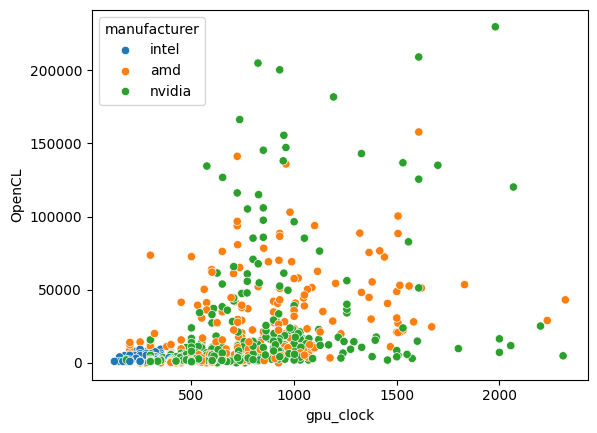

In [33]:
sns.scatterplot(data=final, x="gpu_clock", y="OpenCL", hue="manufacturer")
plt.show()

In [34]:
final["manufacturer"].unique()

array(['intel', 'amd', 'nvidia'], dtype=object)

In [35]:
fix = px.scatter(final, x="gpu_clock", y="OpenCL", color="manufacturer", hover_data=["product_name", "gpu_clock", "memory_size", "memory_clock", "memory_type", "release_year"])
fix.show()

In [36]:
fix = px.scatter(
    final, 
    x="gpu_clock", 
    y="OpenCL", 
    color="manufacturer", 
    hover_data=["product_name", "gpu_clock", "memory_size", "memory_clock", "memory_type", "release_year"]
)

fix.update_traces(
    customdata=final[["OpenCL", "CUDA", "memory_size", "memory_clock", "memory_type", "release_year"]],
    text=final["product_name"]
)

fix.update_layout(
    updatemenus = [
        dict(
            type="buttons",
            direction="down",
            x=1.15,
            y=0.5,
            showactive=True,
            buttons=[
                dict(
                    label = "OpenCL",
                    method="update",
                    args=[{"y": [final["OpenCL"]]}, {"yaxis": {"title": "OpenCL"}}]
                ),
                dict(
                    label = "CUDA",
                    method="update",
                    args=[{"y": [final["CUDA"]]}, {"yaxis": {"title": "CUDA"}}]
                )
            ]
        )
    ]
)

fix.show()

In [37]:
final[final["release_year"] == 2015][["manufacturer", "product_name", "OpenCL", "CUDA"]]

,manufacturer,product_name,OpenCL,CUDA
254,amd,radeon r9 fury,53458.0,0.0
255,amd,radeon r9 390,46328.0,0.0
256,nvidia,tesla m40,34109.0,31401.0
257,nvidia,quadro m6000,36685.0,32385.0
258,nvidia,geforce gtx titan x,39047.0,33701.0
...,...,...,...,...
333,intel,hd graphics 500,1070.0,0.0
334,intel,hd graphics 405,1751.0,0.0
335,intel,hd graphics 400,1243.0,0.0
336,intel,hd graphics,965.0,0.0


In [38]:
data_dictionary(final)

,Column,Type,Missing Data,Percentage Missing
0,manufacturer,object,0,0.0
1,product_name,object,0,0.0
2,release_year,float64,0,0.0
3,memory_size,float64,0,0.0
4,gpu_clock,int64,0,0.0
5,memory_clock,float64,0,0.0
6,unified_shader,float64,0,0.0
7,texture_mapping_units,int64,0,0.0
8,render_output_units,int64,0,0.0
9,integrated_graphics_processor,bool,0,0.0


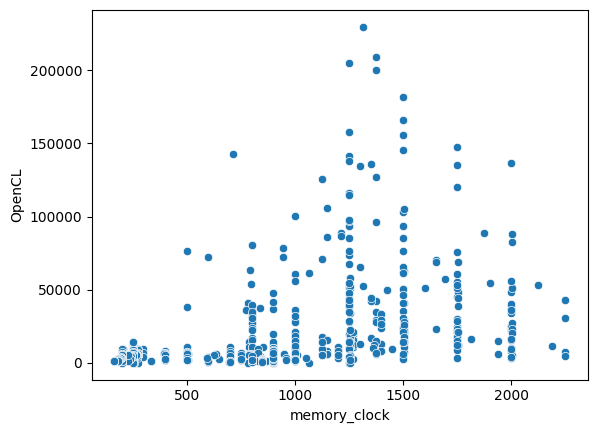

In [39]:
# Plot 1
sns.scatterplot(final, x="memory_clock", y="OpenCL")
plt.show()

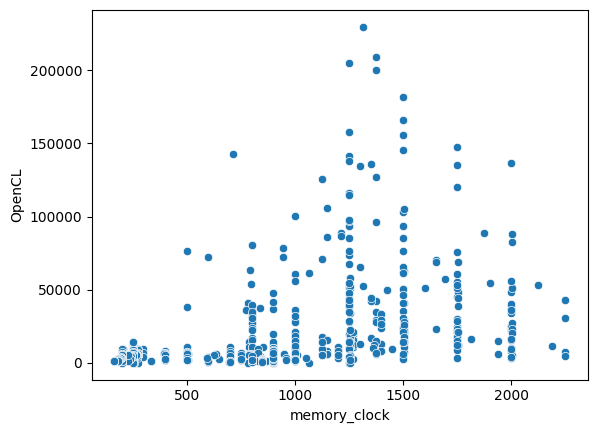

In [40]:
# Plot 2

sns.scatterplot(final, x="memory_clock", y="OpenCL")
plt.show()

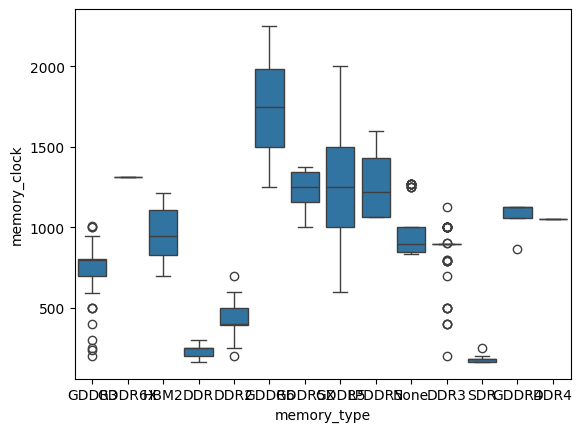

In [41]:
# Plot 3

sns.boxplot(final, x="memory_type", y="memory_clock")
plt.show()

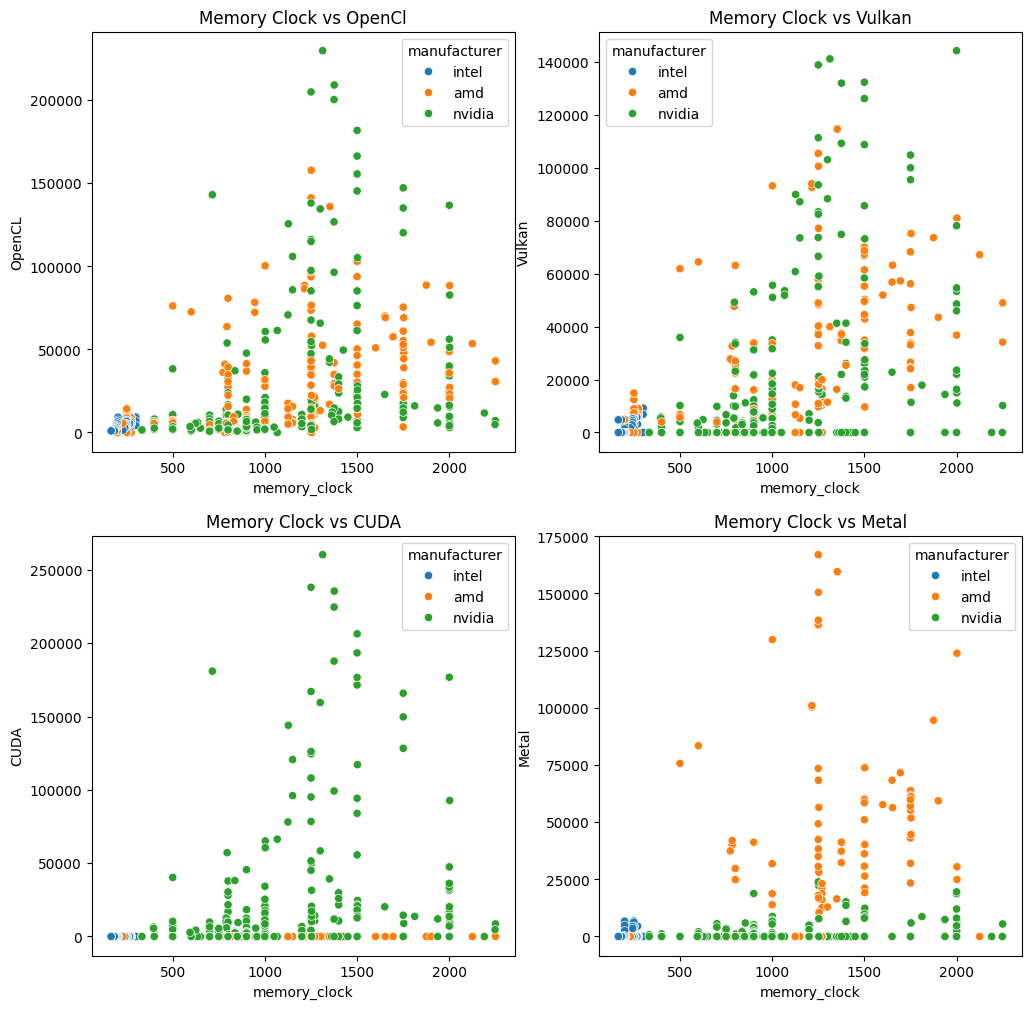

In [42]:
fig, axes = plt.subplots(2,2, figsize=(12,12))

x_variable = "memory_clock"
sns.scatterplot(data=final, x=x_variable, y="OpenCL", ax=axes[0, 0], hue="manufacturer")
axes[0,0].set(title=f"{x_variable.replace("_", " ").title()} vs OpenCl")
sns.scatterplot(data=final, x=x_variable, y="Vulkan", ax=axes[0, 1], hue="manufacturer")
axes[0,1].set(title=f"{x_variable.replace("_", " ").title()} vs Vulkan")
sns.scatterplot(data=final, x=x_variable, y="CUDA", ax=axes[1,0], hue="manufacturer")
axes[1,0].set(title=f"{x_variable.replace("_", " ").title()} vs CUDA")
sns.scatterplot(data=final, x=x_variable, y="Metal", ax=axes[1,1], hue="manufacturer")
axes[1,1].set(title=f"{x_variable.replace("_", " ").title()} vs Metal")

plt.show()

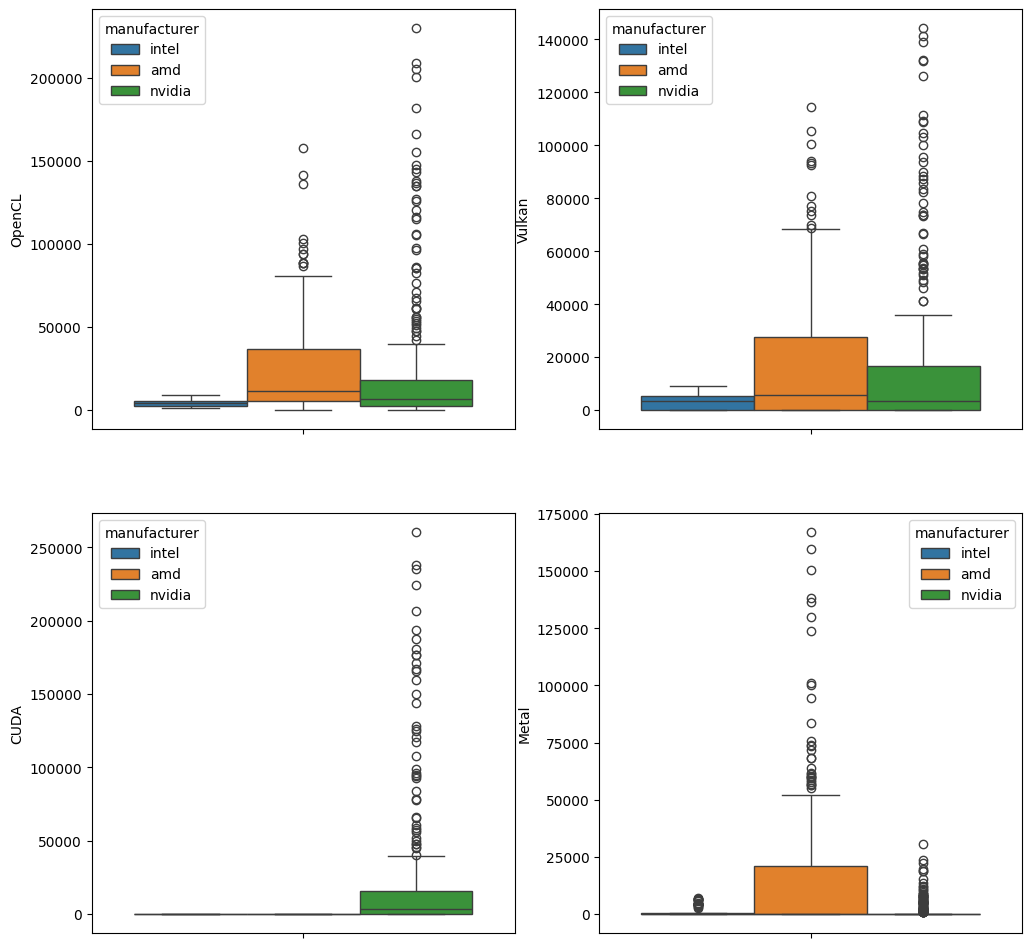

In [43]:
fig, axes = plt.subplots(2,2, figsize=(12,12))

sns.boxplot(data=final, y="OpenCL", ax=axes[0, 0], hue="manufacturer")
sns.boxplot(data=final, y="Vulkan", ax=axes[0, 1], hue="manufacturer")
sns.boxplot(data=final, y="CUDA", ax=axes[1,0], hue="manufacturer")
sns.boxplot(data=final, y="Metal", ax=axes[1,1], hue="manufacturer")

plt.show()

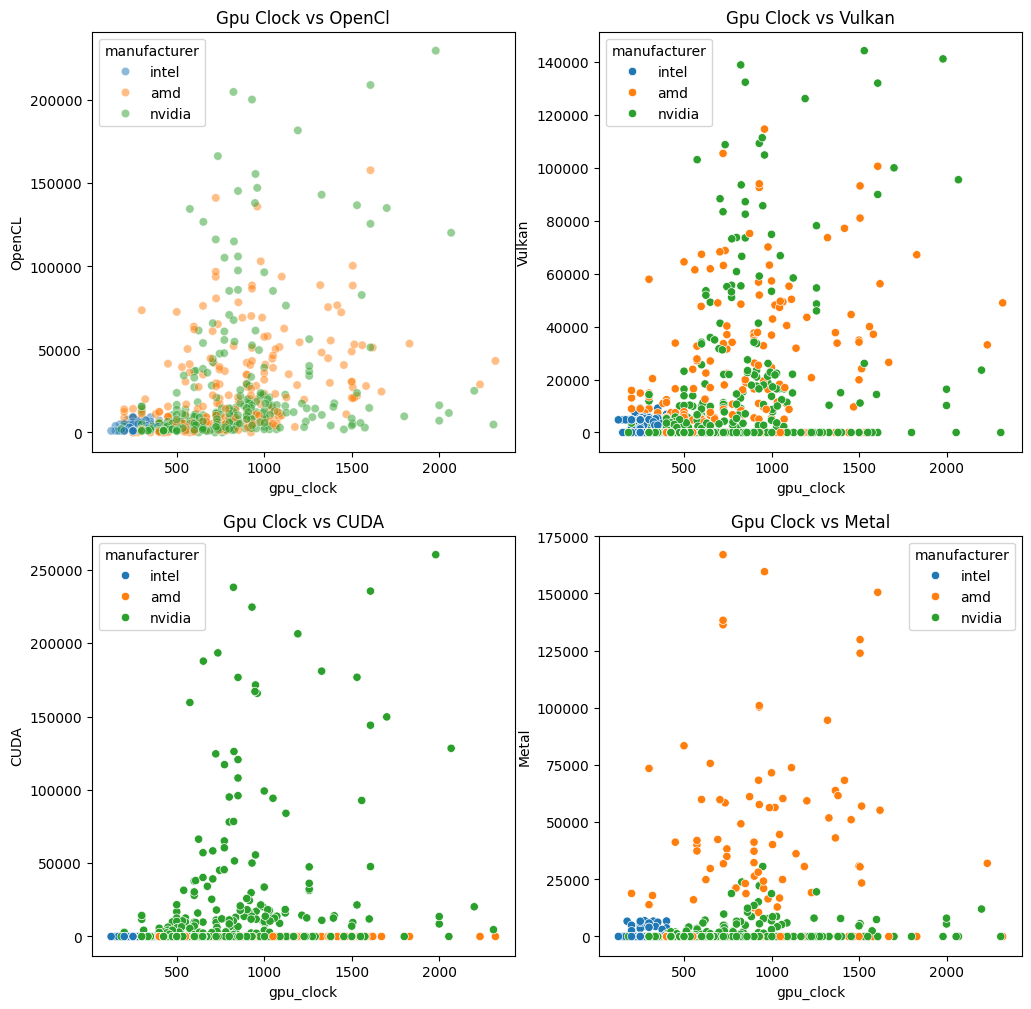

In [44]:
fig, axes = plt.subplots(2,2, figsize=(12,12))

x_variable = "gpu_clock"
sns.scatterplot(data=final, x=x_variable, y="OpenCL", ax=axes[0, 0], hue="manufacturer", alpha=0.5)
axes[0,0].set(title=f"{x_variable.replace("_", " ").title()} vs OpenCl")
sns.scatterplot(data=final, x=x_variable, y="Vulkan", ax=axes[0, 1], hue="manufacturer")
axes[0,1].set(title=f"{x_variable.replace("_", " ").title()} vs Vulkan")
sns.scatterplot(data=final, x=x_variable, y="CUDA", ax=axes[1,0], hue="manufacturer")
axes[1,0].set(title=f"{x_variable.replace("_", " ").title()} vs CUDA")
sns.scatterplot(data=final, x=x_variable, y="Metal", ax=axes[1,1], hue="manufacturer")
axes[1,1].set(title=f"{x_variable.replace("_", " ").title()} vs Metal")

plt.show()

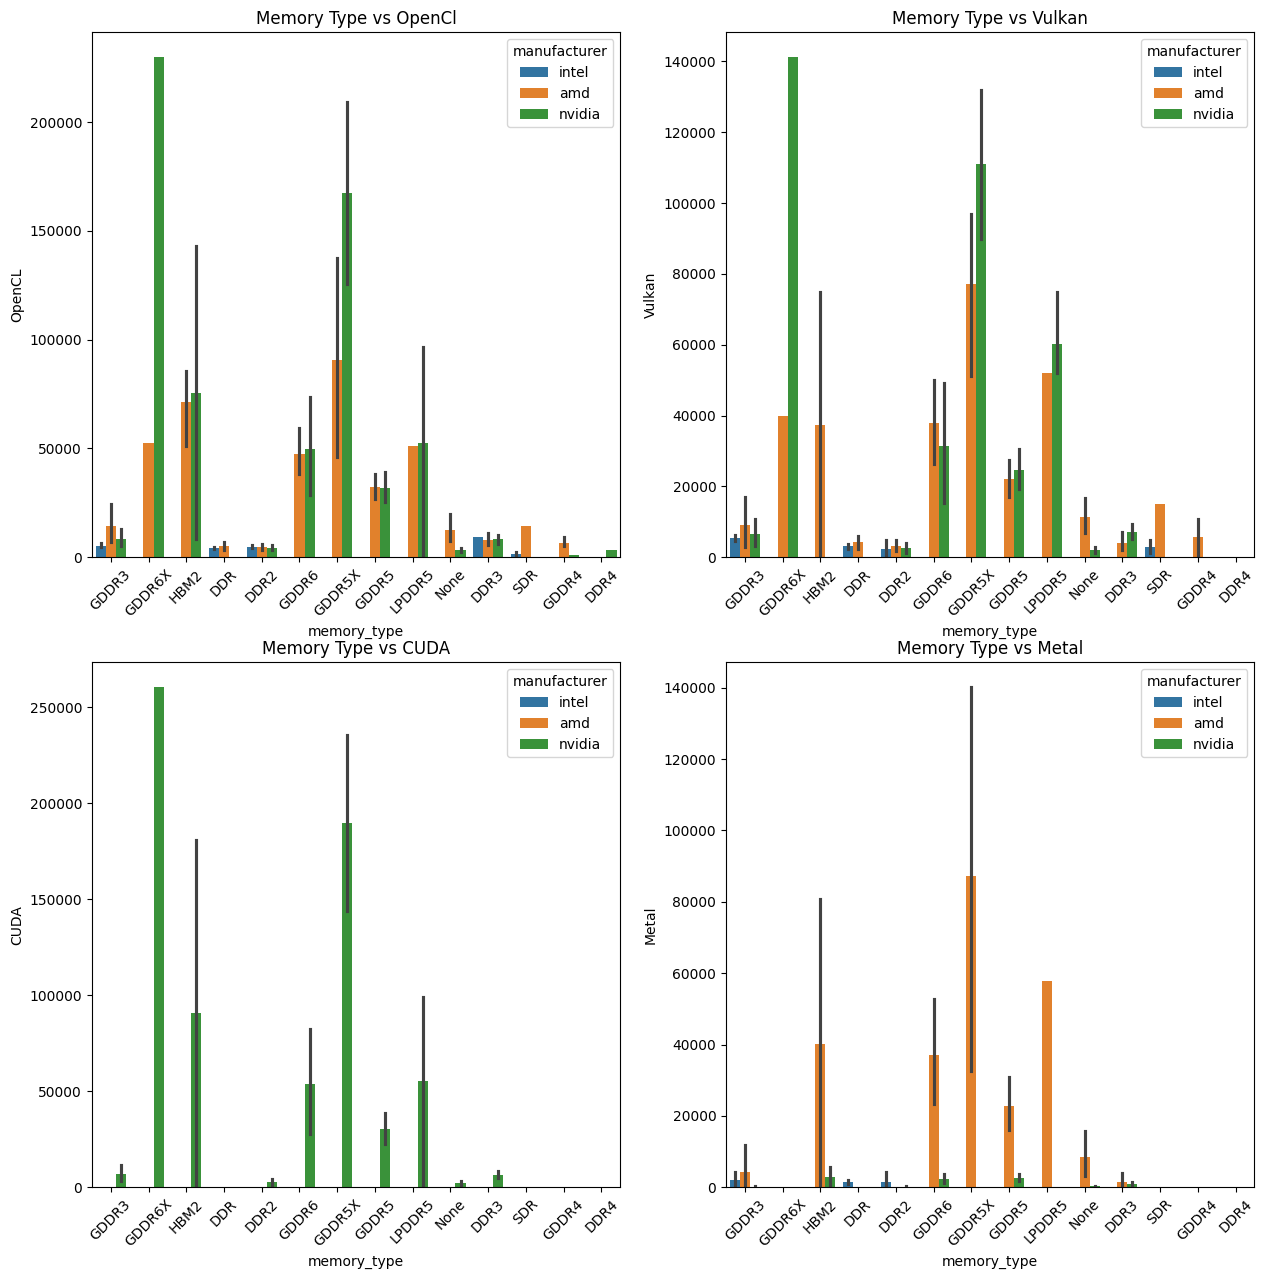

In [45]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

x_variable = "memory_type"
sns.barplot(data=final, x=x_variable, y="OpenCL", ax=axes[0, 0], hue="manufacturer")
axes[0,0].set(title=f"{x_variable.replace("_", " ").title()} vs OpenCl")
sns.barplot(data=final, x=x_variable, y="Vulkan", ax=axes[0, 1], hue="manufacturer")
axes[0,1].set(title=f"{x_variable.replace("_", " ").title()} vs Vulkan")
sns.barplot(data=final, x=x_variable, y="CUDA", ax=axes[1,0], hue="manufacturer")
axes[1,0].set(title=f"{x_variable.replace("_", " ").title()} vs CUDA")
sns.barplot(data=final, x=x_variable, y="Metal", ax=axes[1,1], hue="manufacturer")
axes[1,1].set(title=f"{x_variable.replace("_", " ").title()} vs Metal")

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

plt.show()

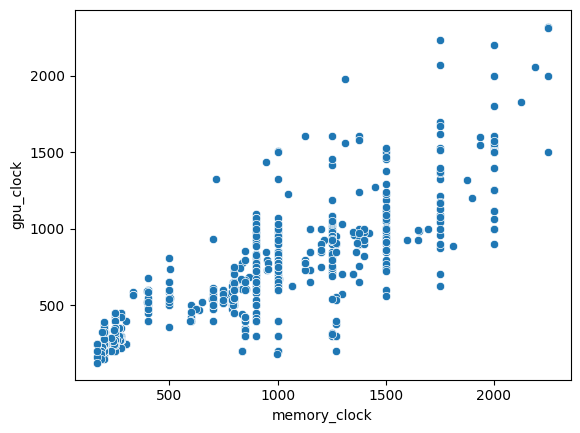

In [46]:
sns.scatterplot(data=final, x="memory_clock", y="gpu_clock")
plt.show()

In [47]:
X = final[["memory_clock"]]
y = final[["gpu_clock"]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

regression = LinearRegression()
regression.fit(x_train, y_train)
regression.score(x_test, y_test)

0.686674965828511

In [48]:
x_const = sm.add_constant(X)
model = sm.OLS(y, x_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              gpu_clock   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     1195.
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          1.04e-148
Time:                        03:19:51   Log-Likelihood:                -4412.8
No. Observations:                 644   AIC:                             8830.
Df Residuals:                     642   BIC:                             8839.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          130.7633     19.381      6.747   

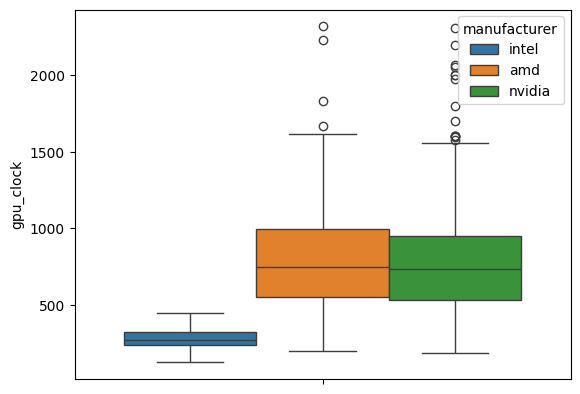

In [49]:
sns.boxplot(data=final, y="gpu_clock", hue="manufacturer")
plt.show()

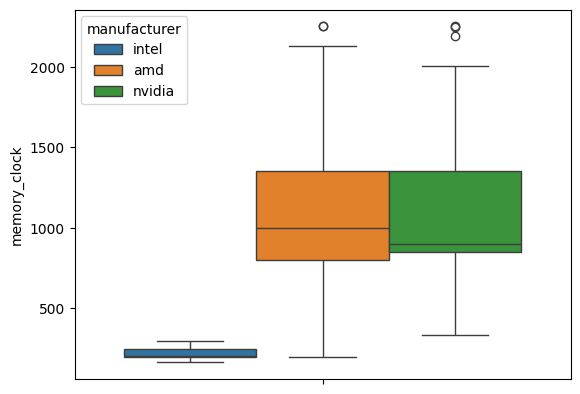

In [50]:
sns.boxplot(data=final, y="memory_clock", hue="manufacturer")
plt.show()

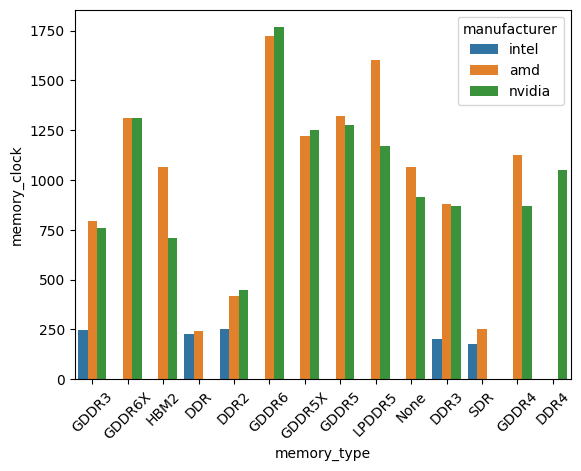

In [51]:
sns.barplot(data=final, x="memory_type", y="memory_clock", hue="manufacturer", errorbar=None)
plt.xticks(rotation=45)
plt.show()

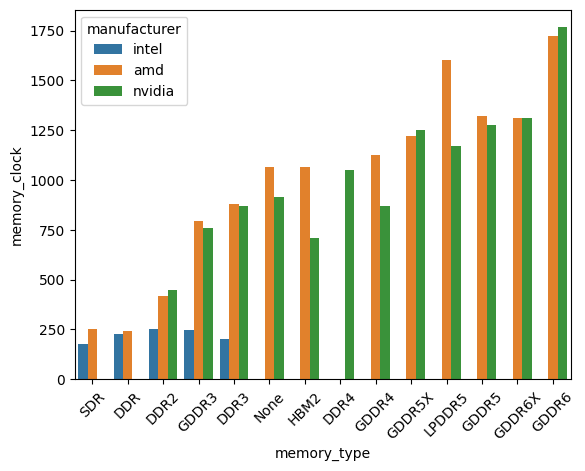

In [52]:
final_2 = final[final["memory_type"] != None]
order = (final_2.groupby("memory_type")["memory_clock"].mean().sort_values().index)
sns.barplot(data=final_2, x="memory_type", y="memory_clock", hue="manufacturer", errorbar=None, order=order)
plt.xticks(rotation=45)
plt.show()

In [53]:
final.head()

,manufacturer,product_name,release_year,memory_size,gpu_clock,memory_clock,unified_shader,texture_mapping_units,render_output_units,integrated_graphics_processor,bus,memory_type,gpu_chip,CUDA,Metal,OpenCL,Vulkan
0,intel,uhd graphics 730,2023.0,12.0,400,300.0,5120.0,4,4,False,PCIe 1.0 x16,GDDR3,RV410,0.0,0.0,6934.0,6861.0
1,amd,radeon rx 6500 xt,2022.0,4.0,1560,1313.0,10752.0,336,112,False,PCIe 4.0 x16,GDDR6X,GA102,0.0,0.0,52512.0,39991.0
2,nvidia,geforce rtx 3090 ti,2022.0,24.0,1980,1313.0,7168.0,224,80,False,PCIe 4.0 x16,GDDR6X,AD104,260346.0,0.0,229738.0,141134.0
3,amd,radeon rx 6800s,2022.0,8.0,852,945.0,4096.0,256,64,False,PCIe 3.0 x16,HBM2,Vega 10,0.0,0.0,78332.0,0.0
4,amd,radeon rx 6700s,2022.0,8.0,1440,945.0,4096.0,256,64,False,PCIe 3.0 x16,HBM2,Vega 10,0.0,0.0,72317.0,0.0


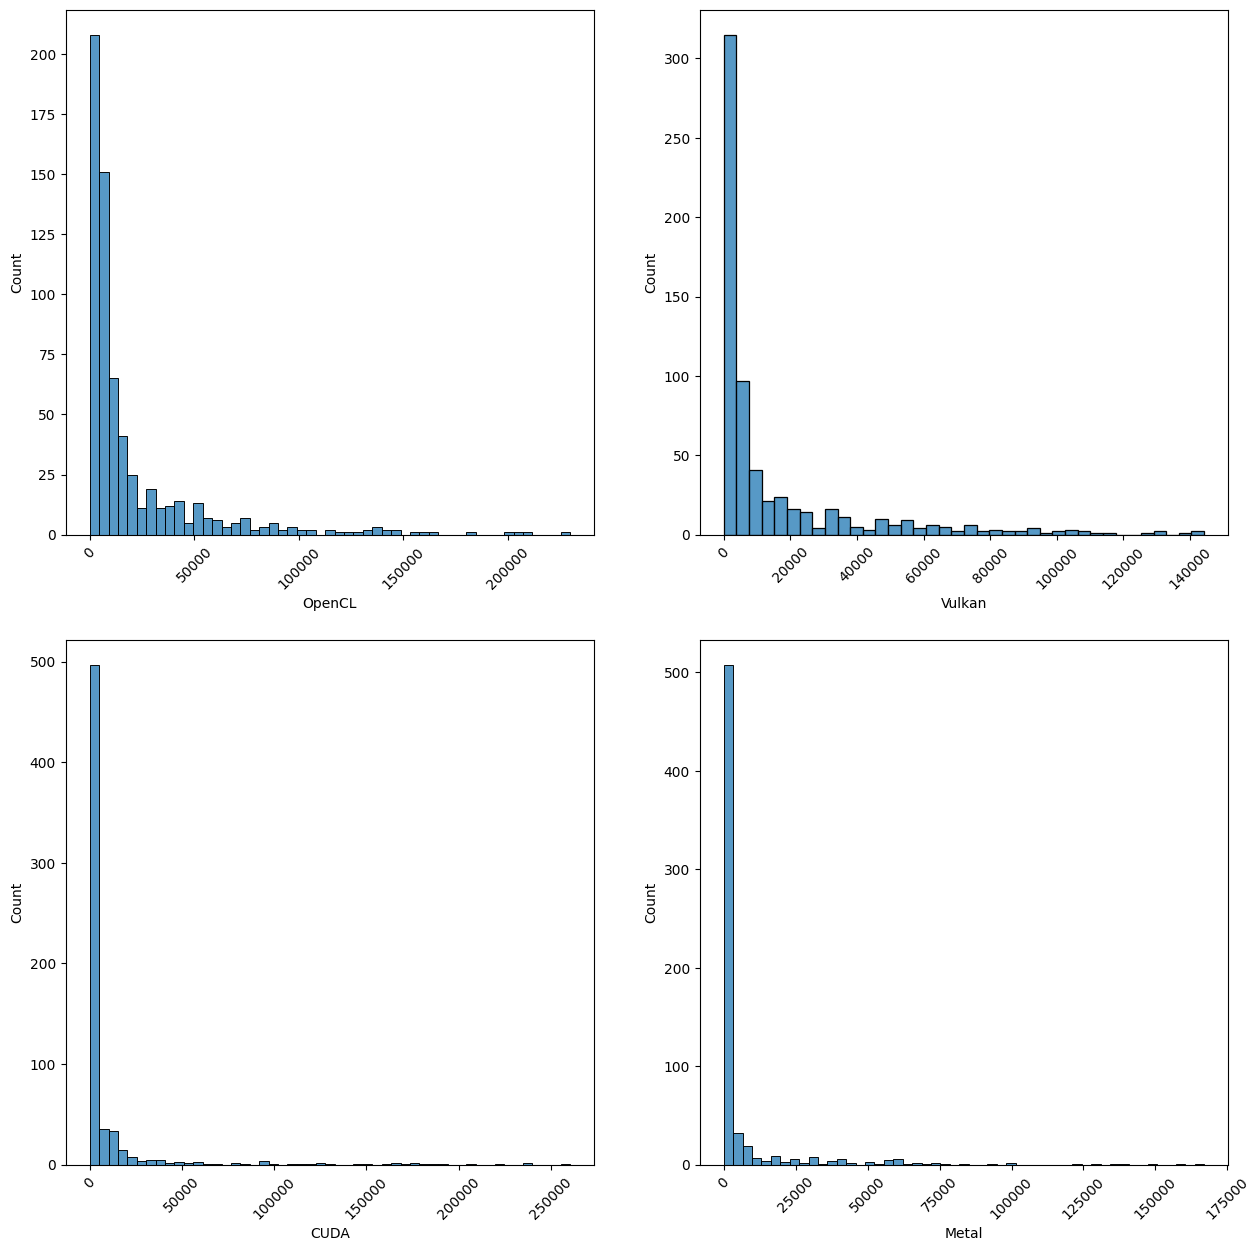

In [54]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

sns.histplot(data=final, x="OpenCL", ax=axes[0, 0])
sns.histplot(data=final, x="Vulkan", ax=axes[0, 1])
sns.histplot(data=final, x="CUDA",ax=axes[1,0])
sns.histplot(data=final, x="Metal", ax=axes[1,1])

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

plt.show()

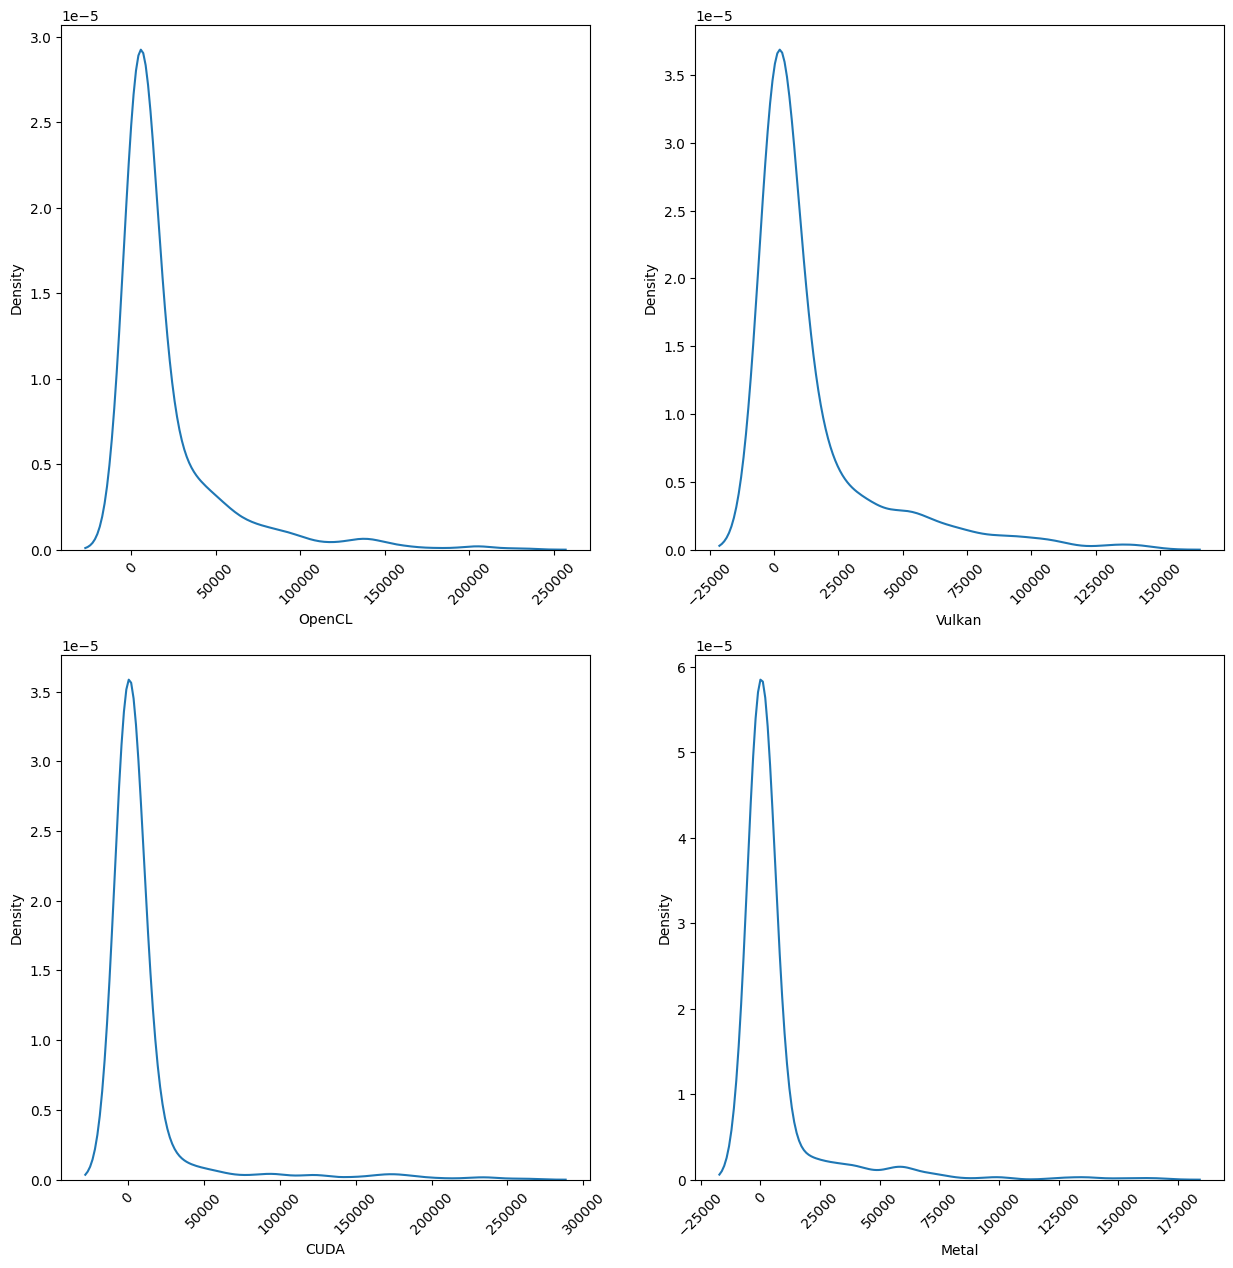

In [55]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

sns.kdeplot(data=final, x="OpenCL", ax=axes[0, 0])
sns.kdeplot(data=final, x="Vulkan", ax=axes[0, 1])
sns.kdeplot(data=final, x="CUDA",ax=axes[1,0])
sns.kdeplot(data=final, x="Metal", ax=axes[1,1])

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

plt.show()

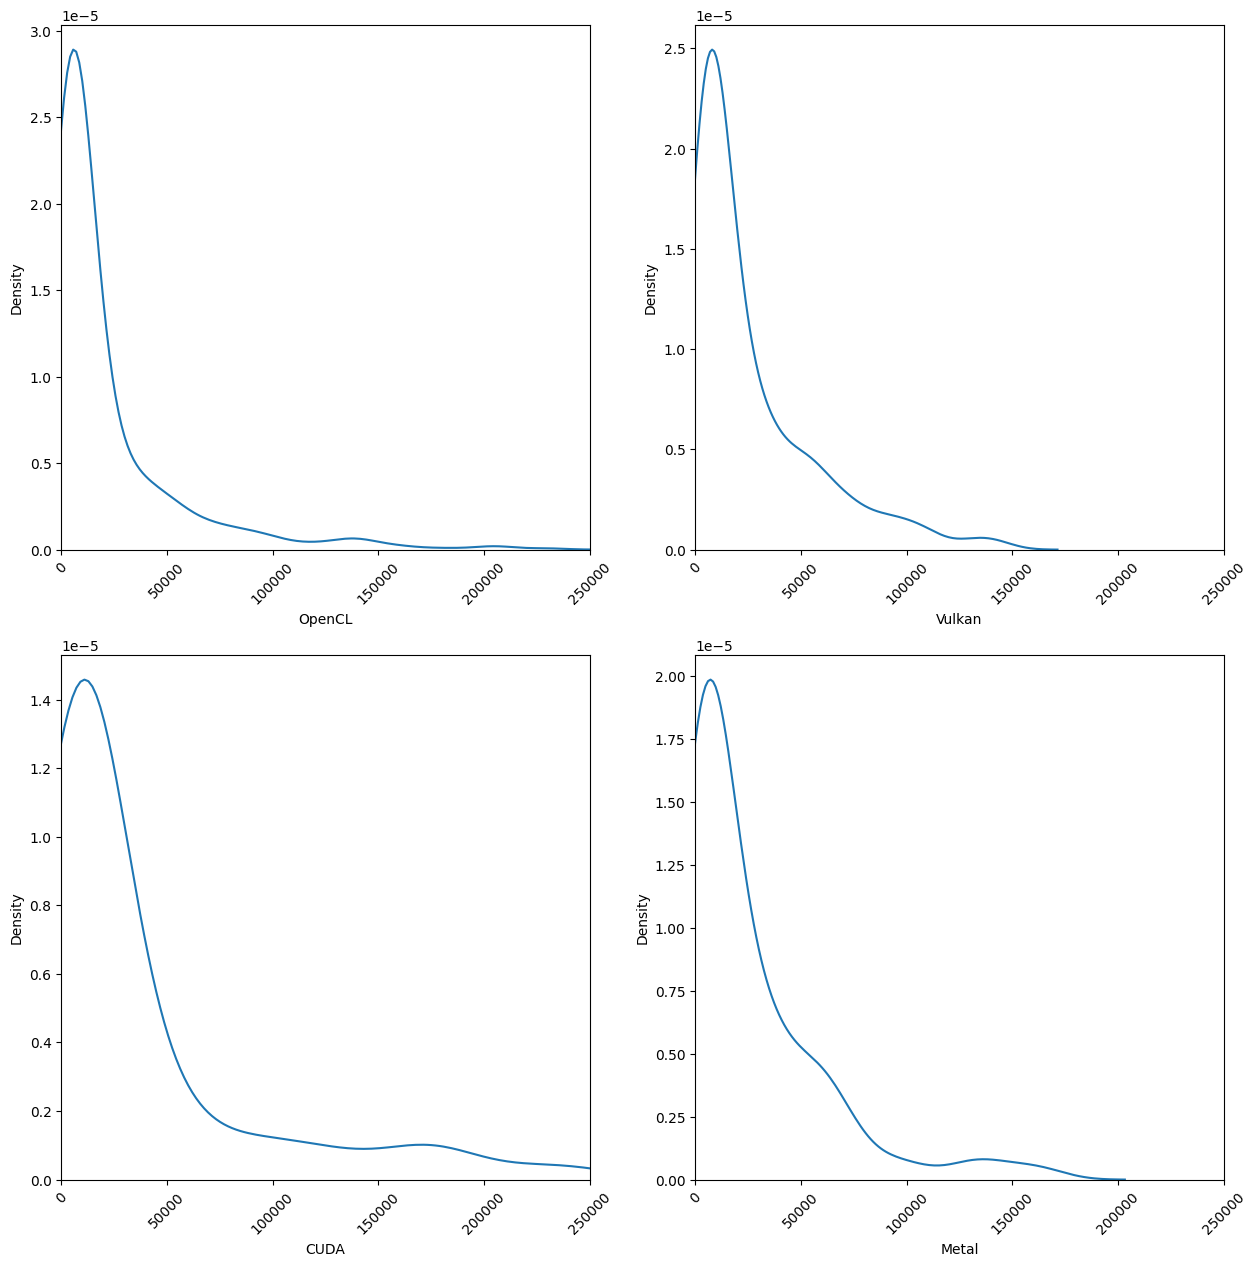

In [56]:
opencl_data = final[final["OpenCL"] != 0]
vulkan_data = final[final["Vulkan"] != 0]
metal_data = final[final["Metal"] != 0]
cuda_data = final[final["CUDA"] != 0]

fig, axes = plt.subplots(2,2, figsize=(15,15))

sns.kdeplot(data=opencl_data, x="OpenCL", ax=axes[0, 0])
axes[0,0].set_xlim((0,250_000))
sns.kdeplot(data=vulkan_data, x="Vulkan", ax=axes[0, 1])
axes[0,1].set_xlim((0,250_000))
sns.kdeplot(data=cuda_data, x="CUDA",ax=axes[1,0])
axes[1,0].set_xlim((0,250_000))
sns.kdeplot(data=metal_data, x="Metal", ax=axes[1,1])
axes[1,1].set_xlim((0,250_000))

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

plt.show()

In [57]:
print(opencl_data.shape)
print(vulkan_data.shape)
print(metal_data.shape)
print(cuda_data.shape)

(632, 17)
(373, 17)
(170, 17)
(186, 17)


In [58]:
final.columns

Index(['manufacturer', 'product_name', 'release_year', 'memory_size',
       'gpu_clock', 'memory_clock', 'unified_shader', 'texture_mapping_units',
       'render_output_units', 'integrated_graphics_processor', 'bus',
       'memory_type', 'gpu_chip', 'CUDA', 'Metal', 'OpenCL', 'Vulkan'],
      dtype='object')

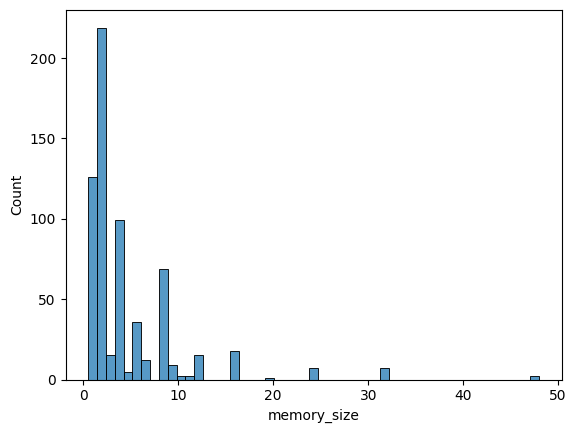

In [59]:
sns.histplot(data=final, x="memory_size")
plt.show()

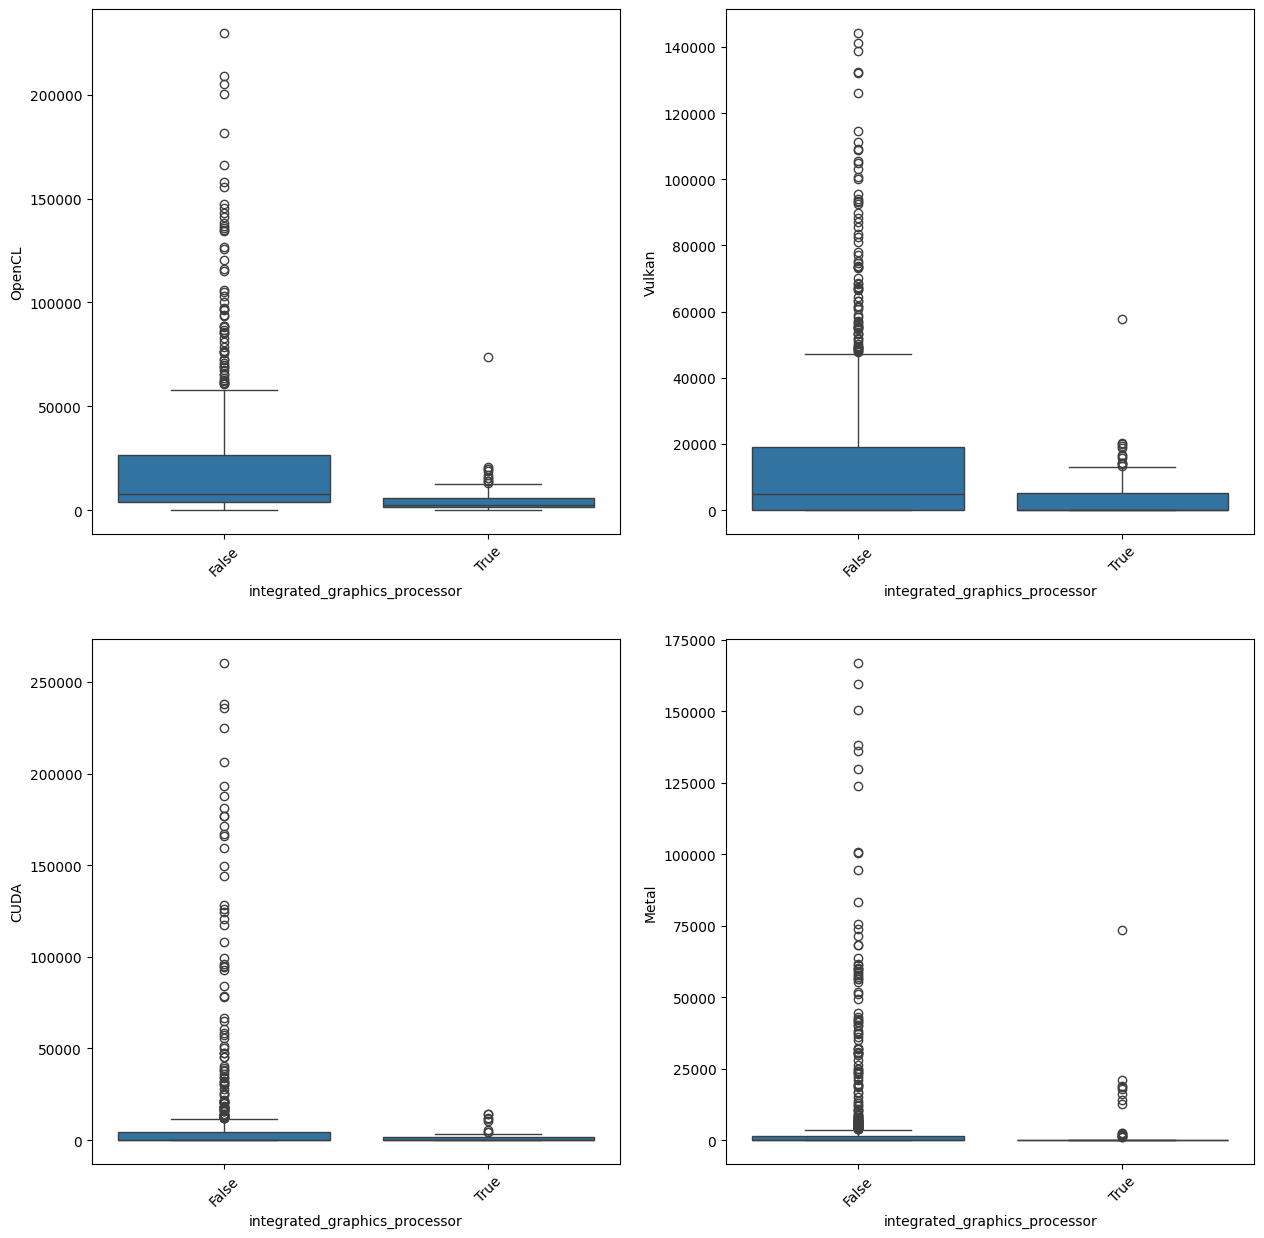

In [60]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

sns.boxplot(data=final, x="integrated_graphics_processor", y="OpenCL", ax=axes[0, 0])
sns.boxplot(data=final, x="integrated_graphics_processor", y="Vulkan", ax=axes[0, 1])
sns.boxplot(data=final, x="integrated_graphics_processor", y="CUDA",ax=axes[1,0])
sns.boxplot(data=final, x="integrated_graphics_processor", y="Metal", ax=axes[1,1])

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

plt.show()

In [61]:
final.head(3)

,manufacturer,product_name,release_year,memory_size,gpu_clock,memory_clock,unified_shader,texture_mapping_units,render_output_units,integrated_graphics_processor,bus,memory_type,gpu_chip,CUDA,Metal,OpenCL,Vulkan
0,intel,uhd graphics 730,2023.0,12.0,400,300.0,5120.0,4,4,False,PCIe 1.0 x16,GDDR3,RV410,0.0,0.0,6934.0,6861.0
1,amd,radeon rx 6500 xt,2022.0,4.0,1560,1313.0,10752.0,336,112,False,PCIe 4.0 x16,GDDR6X,GA102,0.0,0.0,52512.0,39991.0
2,nvidia,geforce rtx 3090 ti,2022.0,24.0,1980,1313.0,7168.0,224,80,False,PCIe 4.0 x16,GDDR6X,AD104,260346.0,0.0,229738.0,141134.0


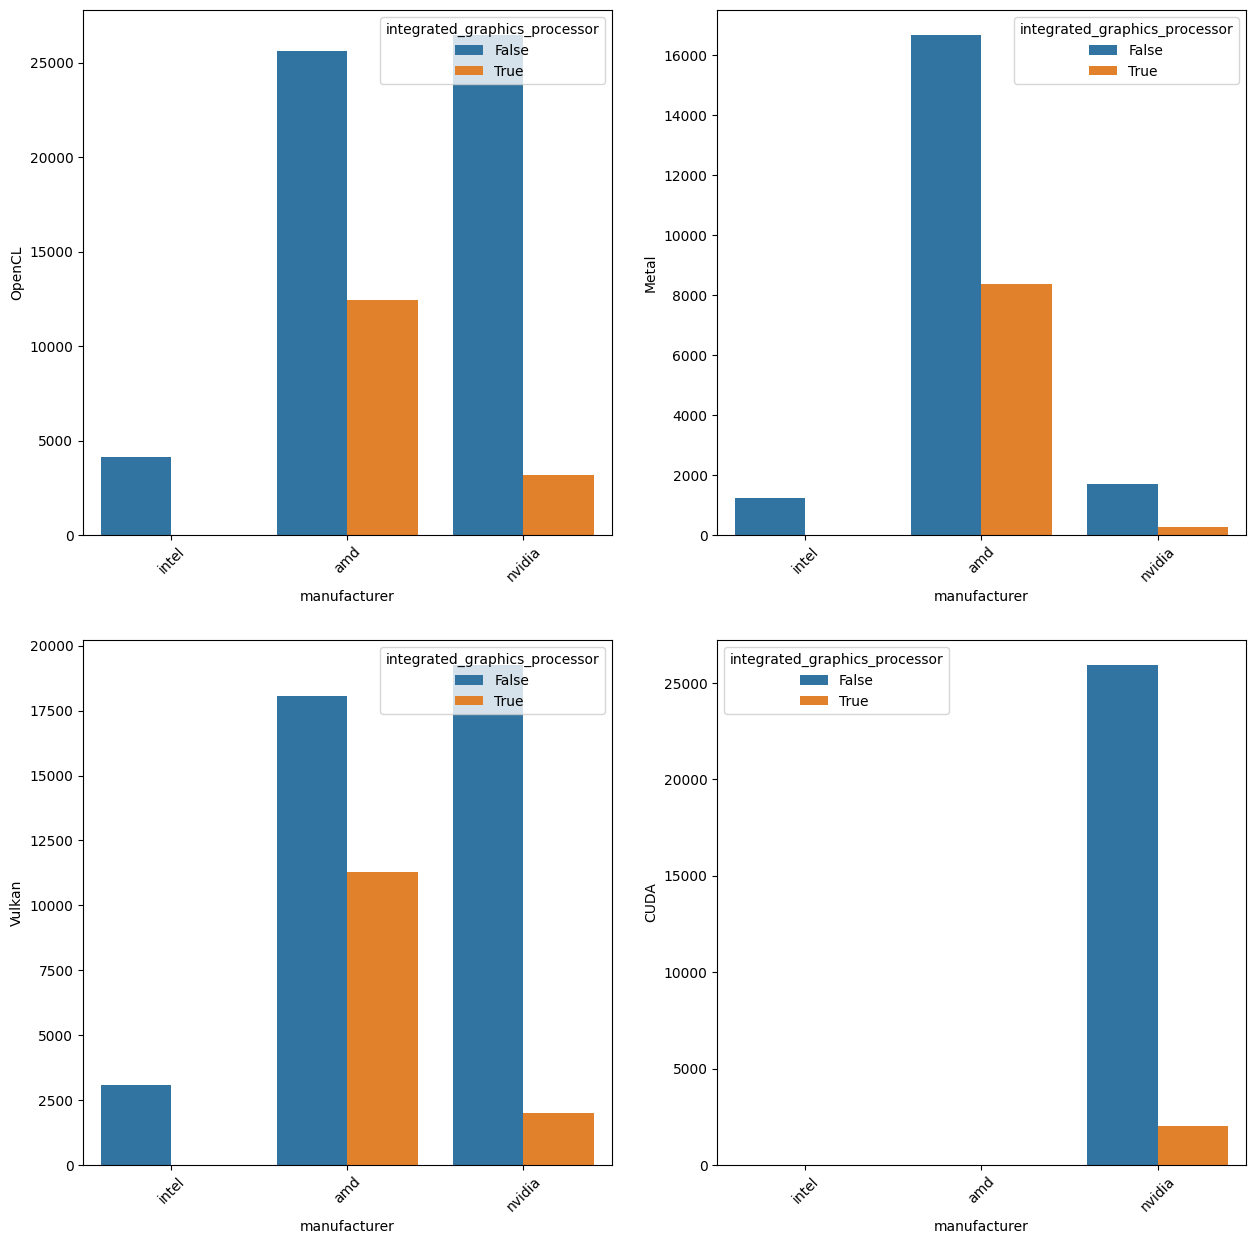

In [62]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

sns.barplot(data=final,x="manufacturer", y="OpenCL", hue="integrated_graphics_processor", ax=axes[0, 0], errorbar=None)
sns.barplot(data=final, x="manufacturer", y="Metal", hue="integrated_graphics_processor", ax=axes[0, 1], errorbar=None)
sns.barplot(data=final, x="manufacturer", y="Vulkan", hue="integrated_graphics_processor",ax=axes[1,0], errorbar=None)
sns.barplot(data=final, x="manufacturer", y="CUDA", hue="integrated_graphics_processor", ax=axes[1,1], errorbar=None)

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(45)

plt.show()

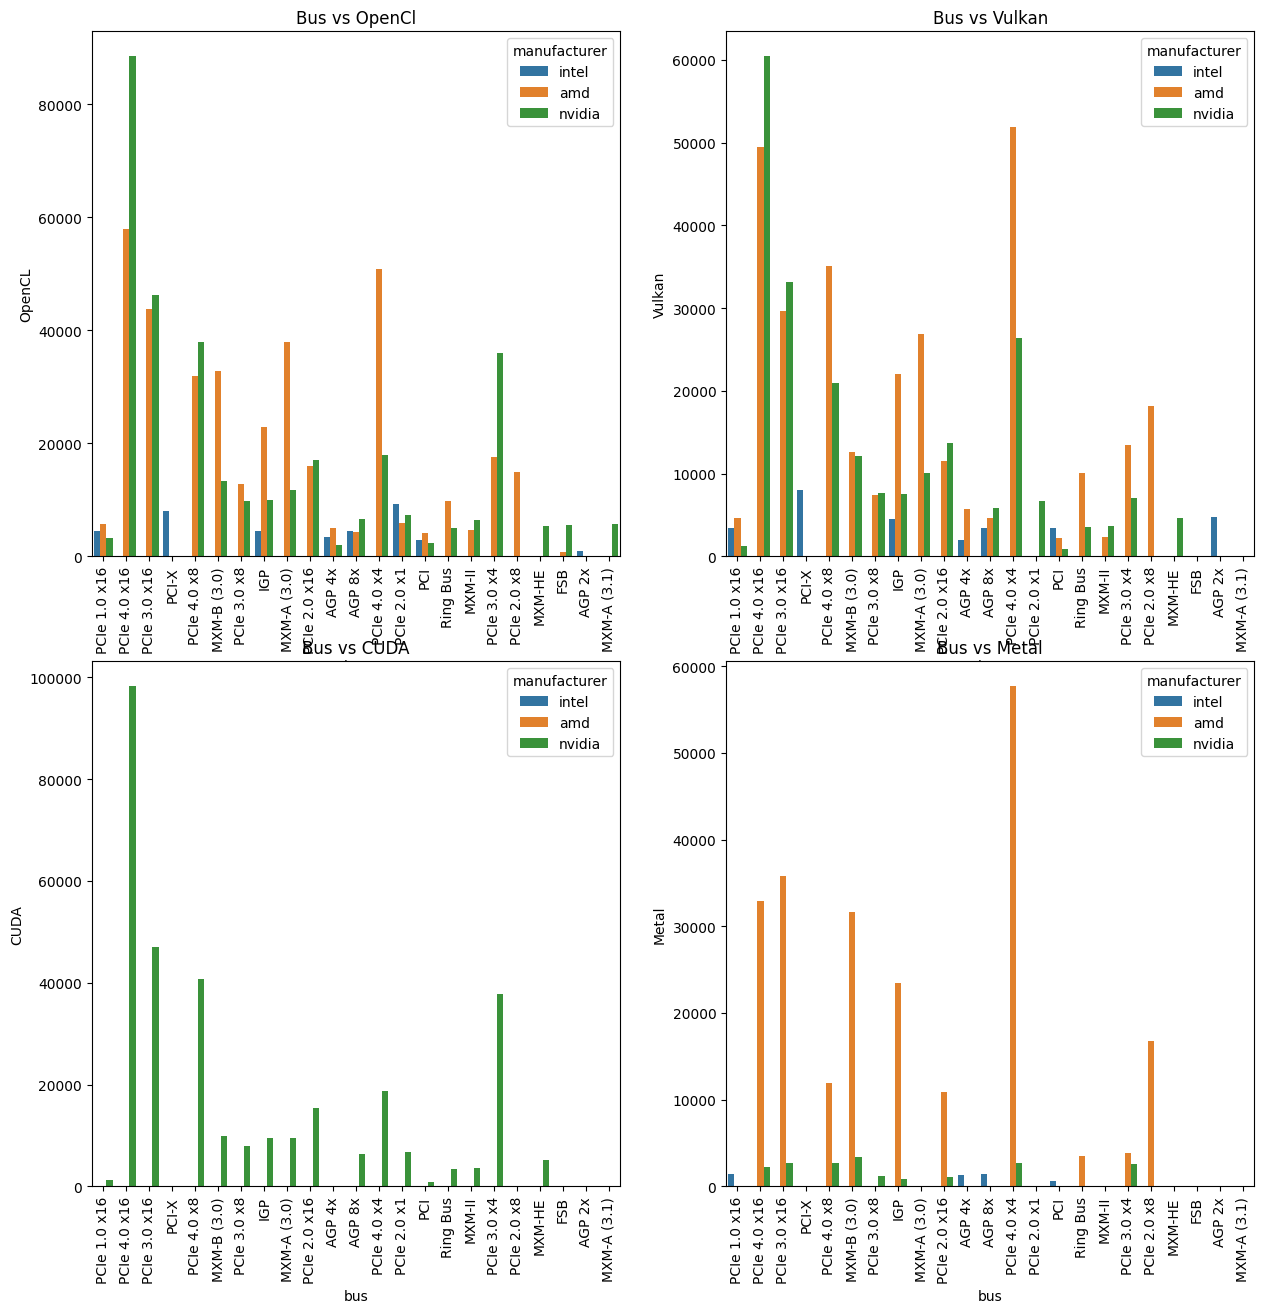

In [63]:
fig, axes = plt.subplots(2,2, figsize=(15,15))

x_variable = "bus"
sns.barplot(data=final, x=x_variable, y="OpenCL", ax=axes[0, 0], hue="manufacturer", errorbar=None)
axes[0,0].set(title=f"{x_variable.replace("_", " ").title()} vs OpenCl")
sns.barplot(data=final, x=x_variable, y="Vulkan", ax=axes[0, 1], hue="manufacturer", errorbar=None)
axes[0,1].set(title=f"{x_variable.replace("_", " ").title()} vs Vulkan")
sns.barplot(data=final, x=x_variable, y="CUDA", ax=axes[1,0], hue="manufacturer", errorbar=None)
axes[1,0].set(title=f"{x_variable.replace("_", " ").title()} vs CUDA")
sns.barplot(data=final, x=x_variable, y="Metal", ax=axes[1,1], hue="manufacturer", errorbar=None)
axes[1,1].set(title=f"{x_variable.replace("_", " ").title()} vs Metal")

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(90)

plt.show()

In [64]:
len(final["gpu_chip"].unique())

212

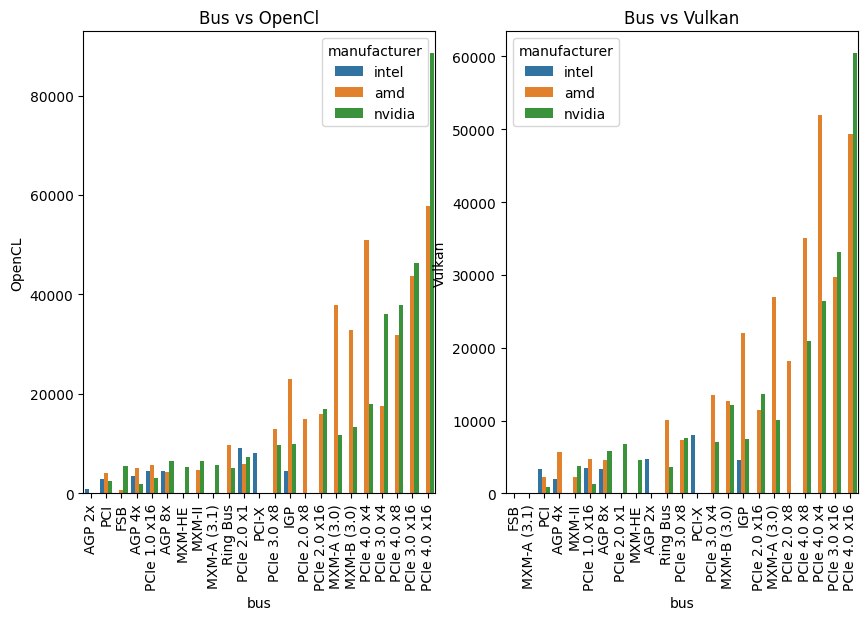

In [65]:
fig, axes = plt.subplots(1,2, figsize=(10,6))

order_opencl = (final.groupby("bus")["OpenCL"].mean().sort_values().index)
order_vulkan = (final.groupby("bus")["Vulkan"].mean().sort_values().index)

x_variable = "bus"
sns.barplot(data=final, x=x_variable, y="OpenCL", ax=axes[0], hue="manufacturer", errorbar=None, order=order_opencl)
axes[0].set(title=f"{x_variable.replace("_", " ").title()} vs OpenCl")
sns.barplot(data=final, x=x_variable, y="Vulkan", ax=axes[1], hue="manufacturer", errorbar=None, order=order_vulkan)
axes[1].set(title=f"{x_variable.replace("_", " ").title()} vs Vulkan")

for ax in axes.flatten():
   for tick in ax.get_xticklabels():
       tick.set_rotation(90)

plt.show()

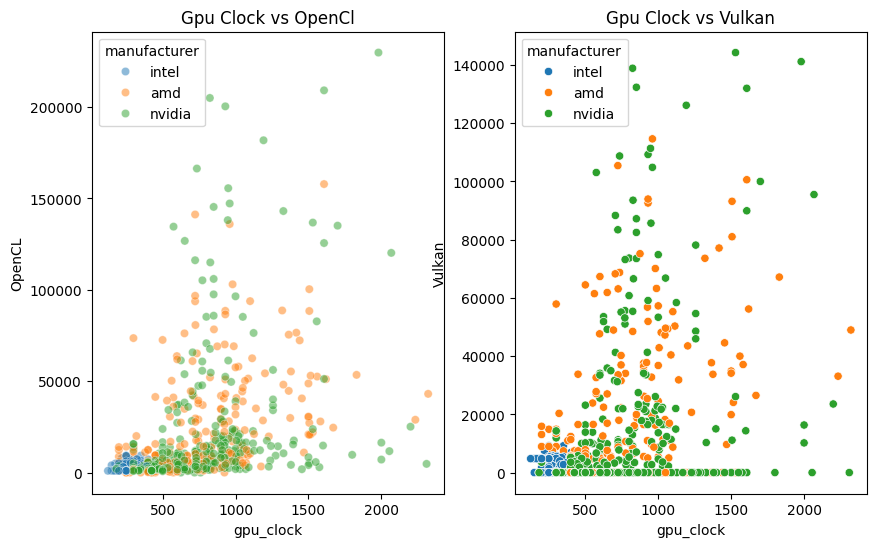

In [66]:
fig, axes = plt.subplots(1,2, figsize=(10,6))

x_variable = "gpu_clock"
sns.scatterplot(data=final, x=x_variable, y="OpenCL", ax=axes[0], hue="manufacturer", alpha=0.5)
axes[0].set(title=f"{x_variable.replace("_", " ").title()} vs OpenCl")
sns.scatterplot(data=final, x=x_variable, y="Vulkan", ax=axes[1], hue="manufacturer")
axes[1].set(title=f"{x_variable.replace("_", " ").title()} vs Vulkan")

plt.show()

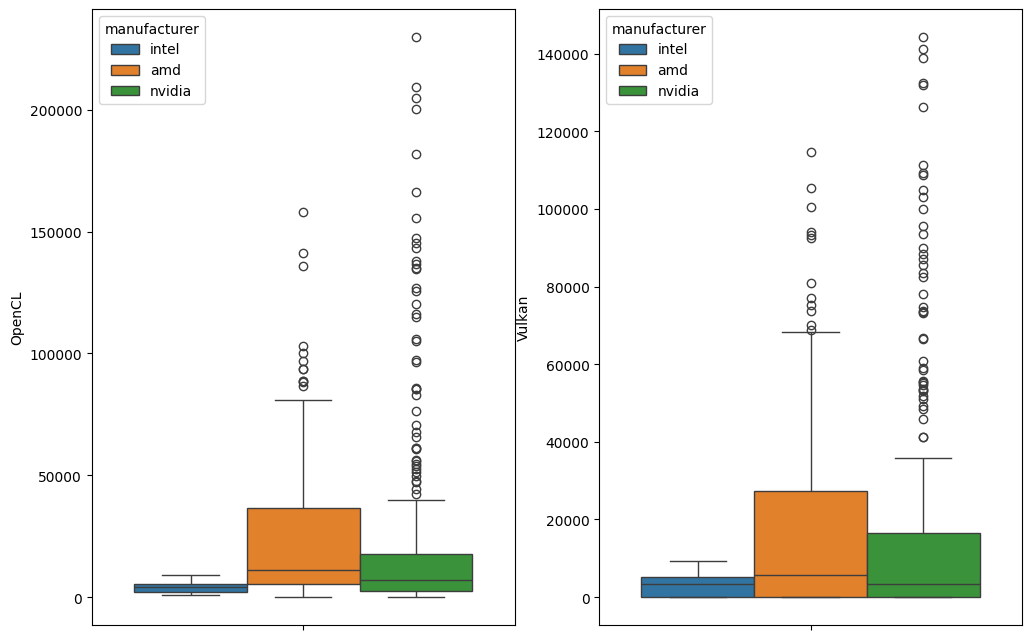

In [67]:
fig, axes = plt.subplots(1,2, figsize=(12,8))

sns.boxplot(data=final, y="OpenCL", ax=axes[0], hue="manufacturer")
sns.boxplot(data=final, y="Vulkan", ax=axes[1], hue="manufacturer")

plt.show()